# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

4. Возмите вариант 1 или 2 
    - Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    - Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )


5. Оцените результат моделирования

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os
import warnings
import itertools
import time

#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


/Users/daniilstv/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


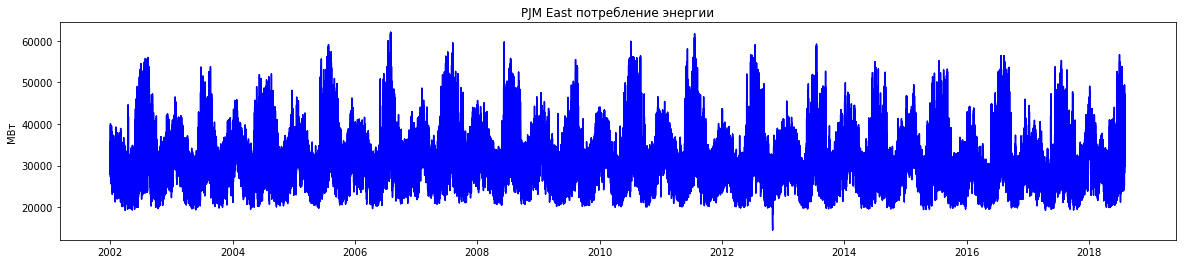

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

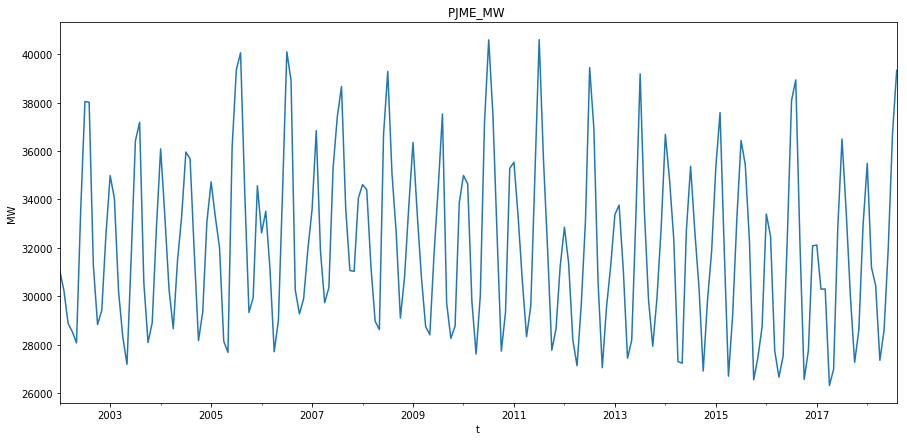

In [4]:
# ...сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

data_m = data.resample('M').mean()
_ = data_m['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

In [5]:
data_m['PJME_MW']


Date
2002-01-31    31075.399731
2002-02-28    30239.166667
2002-03-31    28875.256720
2002-04-30    28534.731572
2002-05-31    28073.653226
                  ...     
2018-04-30    27353.266667
2018-05-31    28599.951613
2018-06-30    32014.469444
2018-07-31    36696.737903
2018-08-31    39331.795918
Freq: M, Name: PJME_MW, Length: 200, dtype: float64

In [6]:
# for lag in [9, 13, 17, 26, 30, 35]:
#     print(f'Count lags - {lag}')
#     sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=lag)
#     sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=lag)
#     plt.show()

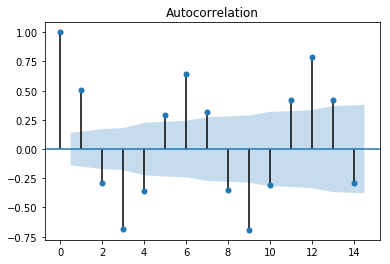

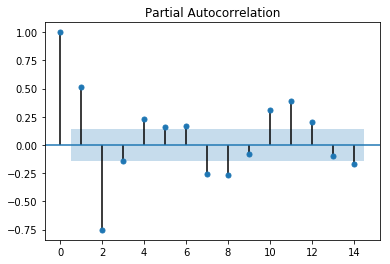

In [7]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=14)
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=14)
plt.show()
# Корреляция годовых, полугодовых значений

In [16]:

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)

# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))



# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [20]:
# pdq = [(1, 2, 2)]

In [23]:
%%time
warnings.filterwarnings("ignore") # отключаем предупреждения


min_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:     
            model = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = model.fit()
            
#             if param_seasonal == (0, 0, 0, 12):
#                 print(f'SARIMA{param}------------------')
                
            if min_aic >= results.aic:
                min_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
#                 print(f'SARIMA{param} x {param_seasonal}3 - AIC:{min_aic}'

                       
        except:
#             print('Error..')
            continue

CPU times: user 1min 27s, sys: 702 ms, total: 1min 27s
Wall time: 48.8 s


In [25]:
print(f'Лучшие параметры {best_pdq} x {best_seasonal_pdq}, при AIC = {min_aic}')

Лучшие параметры (1, 2, 2) x (0, 2, 2, 12), при AIC = 2430.115822386057


In [ ]:
# pdq = [(1, 2, 2)]
# best_seasonal_pdq = [(0, 2, 2, 12)]

In [26]:
model = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],
                                order=best_pdq,
                                seasonal_order=best_seasonal_pdq,
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results_opt = model.fit()

In [27]:
print(results_opt.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 2, 2, 12)   Log Likelihood               -1209.058
Date:                            Thu, 16 Apr 2020   AIC                           2430.116
Time:                                    01:46:11   BIC                           2447.547
Sample:                                         0   HQIC                          2437.200
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

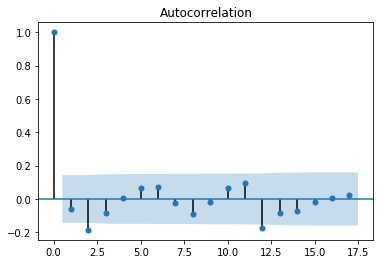

In [28]:
sm.graphics.tsa.plot_acf(results_opt.resid, lags=17)
plt.show()

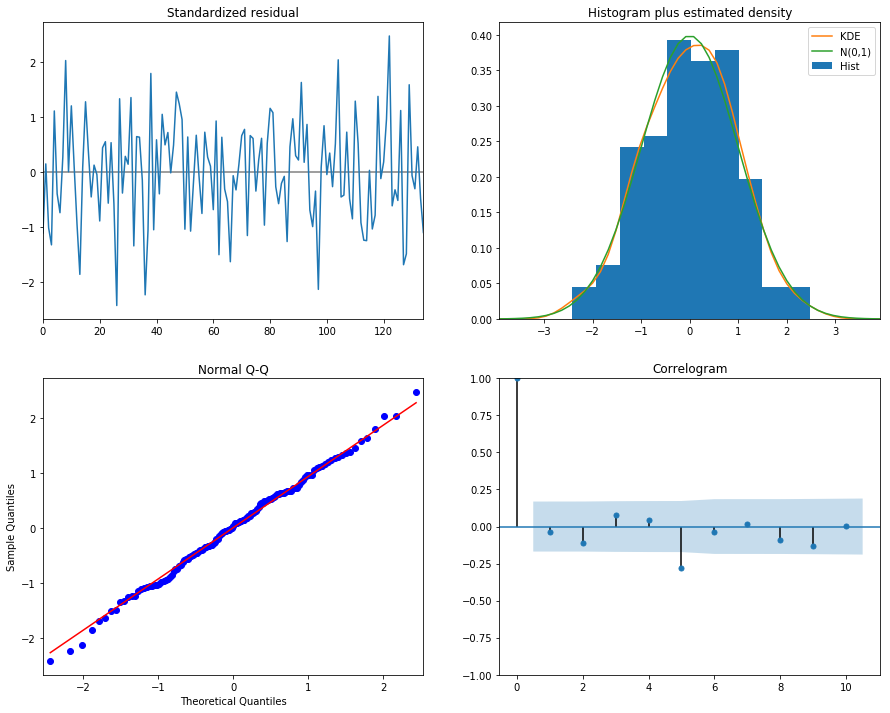

In [29]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

Распределение близко к нормальному, близко к N(0,1). Остатки без корреляции, на уровне шума.

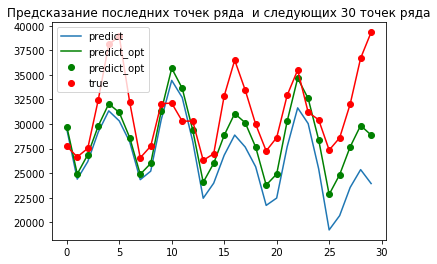

In [49]:
pred_dynamic = results.forecast(30)    
pred_dynamic_opt = results_opt.forecast(30)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.plot(pred_dynamic_opt,'og', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-30:],'or',label='true')
plt.plot(data_m['PJME_MW'].values[-30:],'r')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [53]:

test = sm.tsa.stattools.adfuller(results.resid,regression='ctt')
print( 'adf: ', test[0]) 
print( 'p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print( 'единичных корней нет, ряд стационарен')

adf:  -6.390198962476188
p-value:  1.8927302665078841e-06
Critical values:  {'1%': -4.439375130392411, '5%': -3.8669671600301836, '10%': -3.5746028845956626}
единичных корней нет, ряд стационарен


In [55]:
data_w = data.resample('W').mean()


In [66]:

%%time
model_w = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[:-12],order=best_pdq,
                                seasonal_order=best_seasonal_pdq ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_w = model_w.fit()

CPU times: user 17.1 s, sys: 143 ms, total: 17.3 s
Wall time: 8.93 s


In [67]:
pred_dynamic_w = results_w.forecast(30)

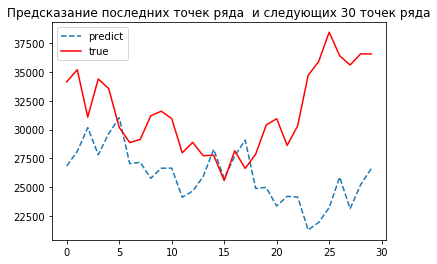

In [68]:
plt.plot(pred_dynamic_w, linestyle='dashed', label='predict' )
plt.plot(data_w['PJME_MW'].values[-30:],'r', label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [76]:
week_data_time = pd.date_range(data_w.index[-12:][0], periods = 30, freq = "W")
month_data_time = pd.date_range(data_m.index[-12:][0], periods = 30, freq = "M")

df_month = pd.DataFrame(index=month_data_time, columns=['PJME_MW'], data=pred_dynamic)
df_week = pd.DataFrame(index=week_data_time, columns=['PJME_MW'], data=pred_dynamic_w)

df_week_month = df_week.asfreq('M', method='pad')

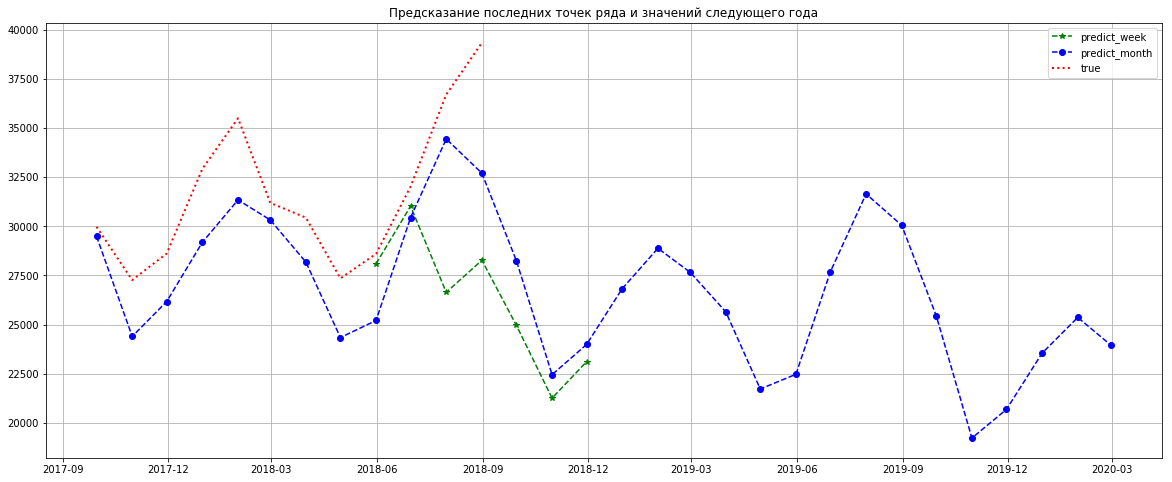

In [77]:
plt.figure(figsize =(20,8))
plt.plot(df_week_month, '*g', linestyle='dashed', label='predict_week')
plt.plot(df_month, 'ob', linestyle='dashed', label='predict_month' )
plt.plot(data_m['PJME_MW'][-12:], ':r', linewidth=2, label='true')
plt.title('Предсказание последних точек ряда и значений следующего года')
plt.grid(True)
plt.legend()

plt.show()

Прогноз на основе месячных значений выглядит более точным.